#  Python Maps and the Australian road network
------------

## Introduction

### Overview

This notebook is a re-implementation of the chapter in the book *Python Maps*, relating to road networks.  Being a chauvanistic Australian, I used the Australian road network to re-imagine some of the  maps from the book 

### Data Source
The data used comes from [https://www.globio.info/download-grip-dataset]

>GRIP global roads database
The Global Roads Inventory Project (GRIP) dataset was developed to provide a more recent and consistent global roads dataset for use in global environmental and biodiversity assessment models like GLOBIO.

--------------
## Implementation

### Notebook magic commands

`watermark` provides reproducability data, `lab_black` enforces a standard Python style

In [1]:
%matplotlib inline

In [2]:
%load_ext watermark

In [3]:
%load_ext lab_black

### Notebook imports

In [4]:
# all imports should go here

import pandas as pd

import geopandas as gpd
import geodatasets as gds

from shapely.geometry import Point

import cartopy.crs as ccrs


import matplotlib.pyplot as plt

--------------------
## Plot Australian road  networks

### Data load
I start with a subset of the data available, that covers Australia.

In [5]:
ROADS_URL = "C:\\Data\\PythonMaps\\Roads\\GRIP4_region7.shp"

r = gpd.read_file(ROADS_URL)

Show first few rows

In [7]:
r.head(3)

,GP_RTP,GP_REX,GP_RAV,GP_RRG,GP_RCY,GP_RSE,GP_RSI,GP_RSY,gp_gripreg,Shape_Leng,geometry
0,5,1,2,24,36,1,27,2004,7,0.017270,"LINESTRING (145.40518 -36.38184, 145.41289 -36..."
1,5,1,2,24,36,1,27,2004,7,0.020821,"LINESTRING (146.86713 -36.12207, 146.88777 -36..."
2,5,1,2,24,36,1,27,2004,7,0.009685,"LINESTRING (146.94077 -36.0642, 146.94037 -36...."


Plot the roads in region 36, which is just the Australian roads (not NZ, etc)

<Axes: >

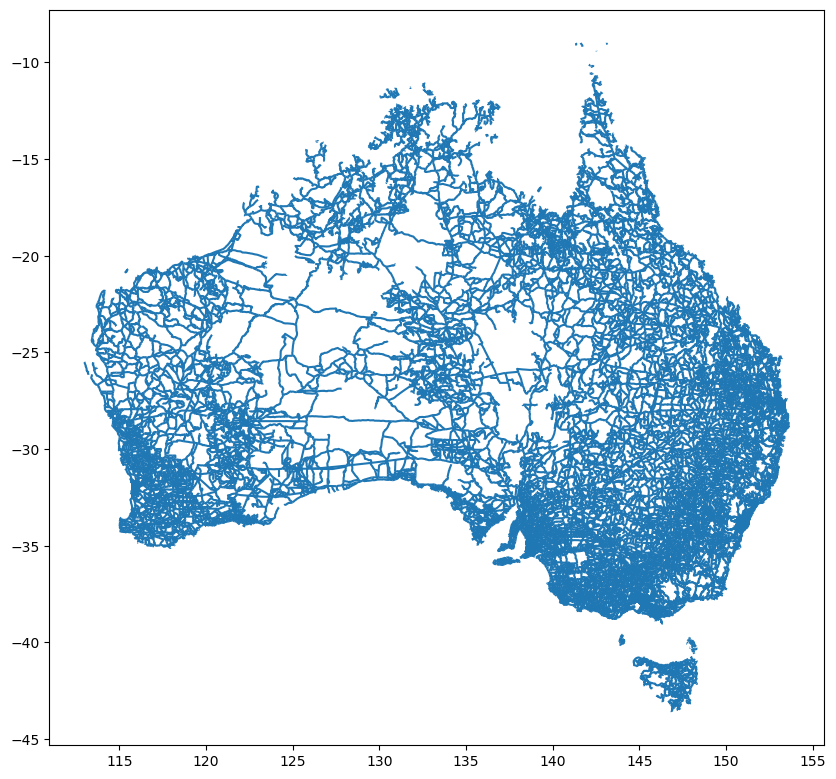

In [8]:
fig, ax = plt.subplots(figsize=(10, 10))

r[r['GP_RCY'] == 36].plot(ax=ax)

Show first few rows of Australia data

In [9]:
r[r['GP_RCY'] == 36].head(3)

,GP_RTP,GP_REX,GP_RAV,GP_RRG,GP_RCY,GP_RSE,GP_RSI,GP_RSY,gp_gripreg,Shape_Leng,geometry
0,5,1,2,24,36,1,27,2004,7,0.017270,"LINESTRING (145.40518 -36.38184, 145.41289 -36..."
1,5,1,2,24,36,1,27,2004,7,0.020821,"LINESTRING (146.86713 -36.12207, 146.88777 -36..."
2,5,1,2,24,36,1,27,2004,7,0.009685,"LINESTRING (146.94077 -36.0642, 146.94037 -36...."


Write out Australian roads data as Parquet file.  This should speed up re-reading that data for later processing

In [10]:
PARQ_URL = 'C:\\Data\\PythonMaps\\Roads\\roads.parquet'
r[r['GP_RCY'] == 36].to_parquet(
    PARQ_URL,
)

--------------------------------------

## Processing subset of data in Parquet format

### Data load and quick mapping

We read Parquet file.  It is noticably quicker than reading the raw Shapefile.

In [12]:
PARQ_URL = 'C:\\Data\\PythonMaps\\Roads\\roads.parquet'

r = gpd.read_parquet(PARQ_URL)
r.head(3)

,GP_RTP,GP_REX,GP_RAV,GP_RRG,GP_RCY,GP_RSE,GP_RSI,GP_RSY,gp_gripreg,Shape_Leng,geometry
0,5,1,2,24,36,1,27,2004,7,0.017270,"LINESTRING (145.40518 -36.38184, 145.41289 -36..."
1,5,1,2,24,36,1,27,2004,7,0.020821,"LINESTRING (146.86713 -36.12207, 146.88777 -36..."
2,5,1,2,24,36,1,27,2004,7,0.009685,"LINESTRING (146.94077 -36.0642, 146.94037 -36...."


We check how big the data set is - not small!

In [14]:
r.shape

(289898, 11)

We re-plot the data set read from the Parquet file, and get the same map (as expected)

<Axes: >

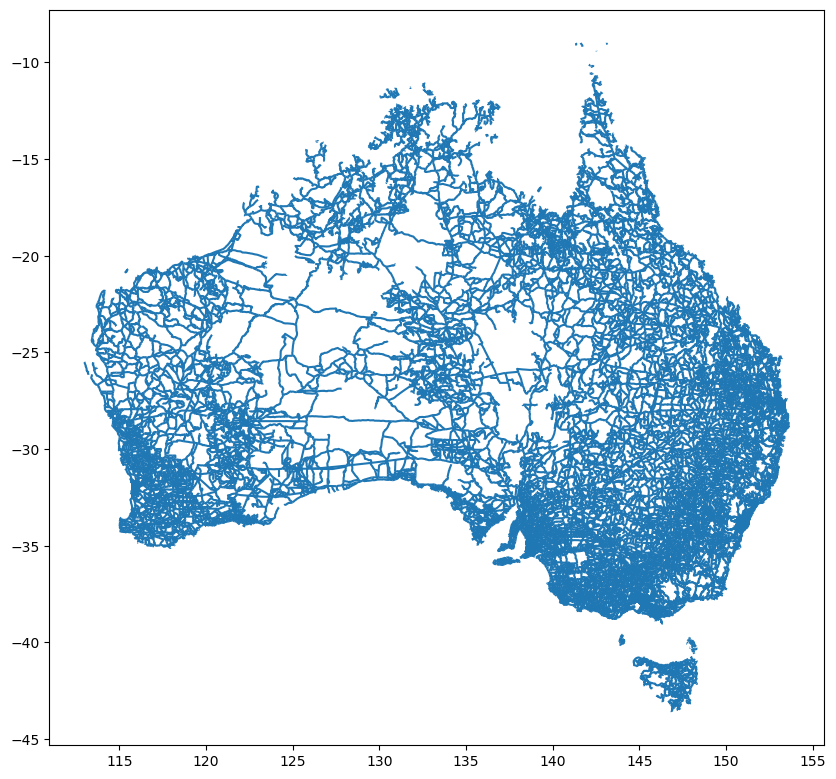

In [9]:
fig, ax = plt.subplots(figsize=(10, 10))

r.plot(ax=ax)

### More subtle mapping

I decided that the map above was too cluttered to allow the road network structure to be seen, so concentrated on distinguishing road type.  `jet`  has a bad name as a colormap but here I think it works.  Now we can see the main long-distance highways more readily.

<Axes: >

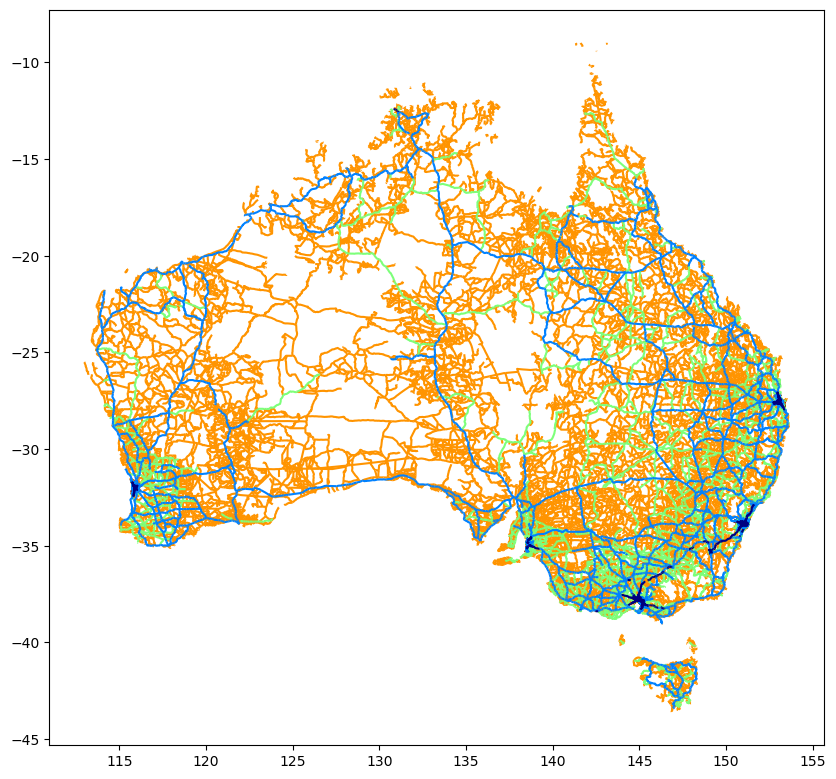

In [10]:
fig, ax = plt.subplots(figsize=(10, 10))

r.plot(
    ax=ax,
    column='GP_RTP',
    categorical=True,
    cmap='jet',
)

### De-cluttering map

In order to de-clutter the map some more, I chose different linewidths for each type of road, and construct an array that maps a linewidth to each road segment.  I also ask for a legend, and set the legend text manually to a more meaning name that the road-type code number

In [15]:
road_width = {1: 2, 2: 1, 3: 0.5, 4: 0.25, 5: 0.1}

road_widths = [road_width[i] for i in r['GP_RTP']]

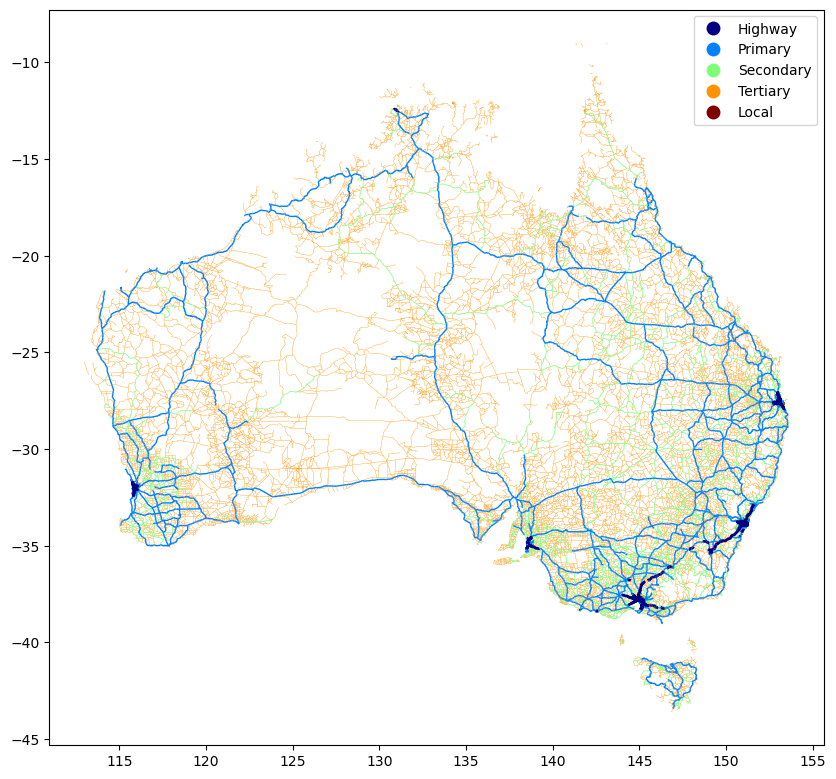

In [16]:
fig, axs = plt.subplots(
    figsize=(10, 10),
)

ax = axs
r.plot(
    ax=ax,
    column='GP_RTP',
    categorical=True,
    cmap='jet',
    legend=True,
    lw=road_widths,
)

leg1 = ax.get_legend()
leg1.get_texts()[0].set_text('Highway')
leg1.get_texts()[1].set_text('Primary')
leg1.get_texts()[2].set_text('Secondary')
leg1.get_texts()[3].set_text('Tertiary')
leg1.get_texts()[4].set_text('Local')

plt.show()

---------------------
## Masking with maps

### Data load
The one thing that is missing from the map above is a coastline.  So I decided to supply a coastline, and zoom into Queensland (my home state)

The Australia Bureau of Statistics provides Digital boundary files, with latest being Australian Statistical Geography Standard (ASGS) Edition 3 [https://www.abs.gov.au/statistics/standards/australian-statistical-geography-standard-asgs-edition-3/jul2021-jun2026/access-and-downloads/digital-boundary-files]

I am in luck, there is a single MULTIPOLYGON that covers Queensland!

In [17]:
oz_url = "C:\\Data\\PythonMaps\\Oz_Borders\\STE_2021_AUST_GDA2020.shp"

In [18]:
oz = gpd.read_file(oz_url)

oz.head()

,STE_CODE21,STE_NAME21,CHG_FLAG21,CHG_LBL21,AUS_CODE21,AUS_NAME21,AREASQKM21,LOCI_URI21,geometry
0,1,New South Wales,0,No change,AUS,Australia,8.007977e+05,http://linked.data.gov.au/dataset/asgsed3/STE/1,"MULTIPOLYGON (((159.0623 -31.50886, 159.06218 ..."
1,2,Victoria,0,No change,AUS,Australia,2.274962e+05,http://linked.data.gov.au/dataset/asgsed3/STE/2,"MULTIPOLYGON (((146.29286 -39.15778, 146.29341..."
2,3,Queensland,0,No change,AUS,Australia,1.730171e+06,http://linked.data.gov.au/dataset/asgsed3/STE/3,"MULTIPOLYGON (((142.5314 -10.68301, 142.53072 ..."
3,4,South Australia,0,No change,AUS,Australia,9.842314e+05,http://linked.data.gov.au/dataset/asgsed3/STE/4,"MULTIPOLYGON (((140.66025 -38.06256, 140.66006..."
4,5,Western Australia,0,No change,AUS,Australia,2.526632e+06,http://linked.data.gov.au/dataset/asgsed3/STE/5,"MULTIPOLYGON (((117.86953 -35.19108, 117.86961..."


Do a quick and easy plot to make certain we have Queensland.

<Axes: >

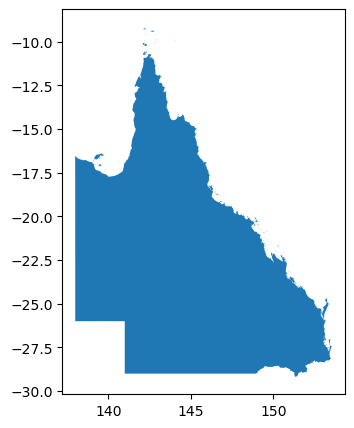

In [19]:
fig, ax = plt.subplots(
    figsize=(5, 5),
)

oz[oz['STE_NAME21'] == 'Queensland'].plot(ax=ax)

### Getting projections right
We have one slight problem, the projections used in our two datasets (Roads data, and Queensland coastline) are different.  Australia tends to have country-specific Datums, not the least because the continental plate we sit upon is moving north at a fair clip.

#### Roads dataset projection

In [25]:
r.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

#### Queensland dataset projection

In [26]:
oz.crs

<Geographic 2D CRS: EPSG:7844>
Name: GDA2020
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: Australia including Lord Howe Island, Macquarie Island, Ashmore and Cartier Islands, Christmas Island, Cocos (Keeling) Islands, Norfolk Island. All onshore and offshore.
- bounds: (93.41, -60.55, 173.34, -8.47)
Datum: Geocentric Datum of Australia 2020
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

Therefore, we convert the Queensland dataset to the projection the Roads dataset uses.

In [27]:
qld = (
    oz[oz['STE_NAME21'] == 'Queensland']
    .to_crs(r.crs)
    .copy()
)

----------------------
### Filtering out non-Qld roads
We use the GeoPandas spatial join predicate `within` to get all the roads tht line within Queensland.

In [28]:
qld_roads = gpd.sjoin(
    r,
    qld,
    predicate='within',
)

### Mapping Qld roads
Lets do a quick and easy plot - looks OK

<Axes: >

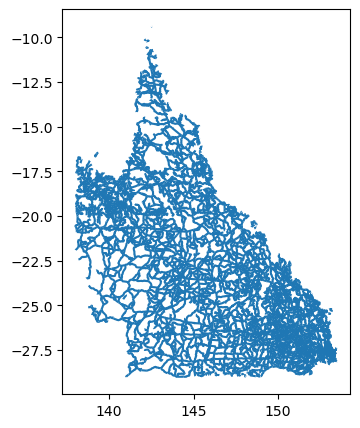

In [29]:
fig, ax = plt.subplots(
    figsize=(5, 5),
)
qld_roads.plot(ax=ax)

Get the linewidths for each road segment, based upon type (as before)

In [30]:
qld_road_widths = [
    road_width[i] for i in qld_roads['GP_RTP']
]

Do a more refined map

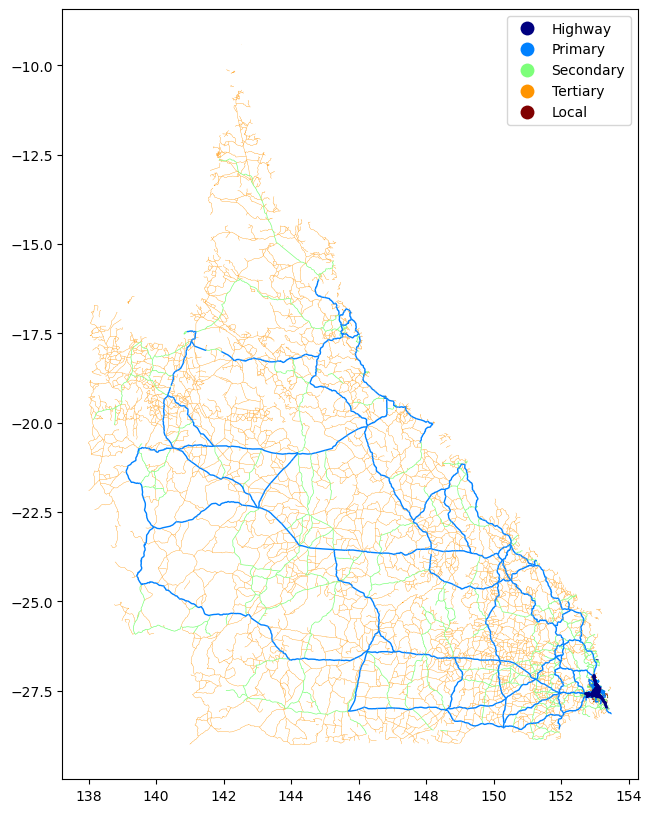

In [31]:
fig, axs = plt.subplots(
    figsize=(10, 10),
)

ax = axs
qld_roads.plot(
    ax=ax,
    column='GP_RTP',
    categorical=True,
    cmap='jet',
    legend=True,
    lw=qld_road_widths,
)

leg1 = ax.get_legend()
leg1.get_texts()[0].set_text('Highway')
leg1.get_texts()[1].set_text('Primary')
leg1.get_texts()[2].set_text('Secondary')
leg1.get_texts()[3].set_text('Tertiary')
leg1.get_texts()[4].set_text('Local')

plt.show()

### Oh! No! A missing road!

Looking at my map, I relaize there is a chunk of Primary road missing (at roughly 21S, 149E).  The problem almost certainly is that the highway there is very close to the coast, and roads dataset has the road sneek a little bit out to sea, and thus is _NOT_ `within` our filtering polygon.

What to do?

My first thought was to use the spatial join `intersects` predicate, but this took longer than my patience would allow, so I went for a different work around.  I would expand the boundary of the Queensland area, and re-run my filtering.

## Use buffered coastline to get missing road data?

Before we can use the `buffer` method to build a buffer around Queensland, we have to choose a projection where the numbers we feed in make sense as a distance.  I choose EPSG:32756, or "WGS 84 / UTM zone 56S". EPSG:32756 has:
>Area: Between 150°E and 156°E, southern hemisphere between 80°S and equator, onshore and offshore. Australia. Papua New Guinea.

UTM (Transverse Mercator) means that we can use metres as a unit of distance.

We check the contents of the Queensland GeoDataFrame again.

In [32]:
qld.head()

,STE_CODE21,STE_NAME21,CHG_FLAG21,CHG_LBL21,AUS_CODE21,AUS_NAME21,AREASQKM21,LOCI_URI21,geometry
2,3,Queensland,0,No change,AUS,Australia,1.730171e+06,http://linked.data.gov.au/dataset/asgsed3/STE/3,"MULTIPOLYGON (((142.5314 -10.68301, 142.53072 ..."


We saved the original CRS (Coordinate Reference System), convert to UTM, expand by 50 km, and convert back the original CRS."

In [33]:
qld_crs = qld.crs
# convert to UTM
qld = qld.to_crs('EPSG:32756').copy()

# expand qld by 50 km
qld['geometry'] = qld['geometry'].buffer(50 * 1000)
qld = qld.to_crs(qld_crs).copy()

Do a quick and easy plot of our expanded filter polygon.  Loks OK (if a little blobby, but that is what we want)

<Axes: >

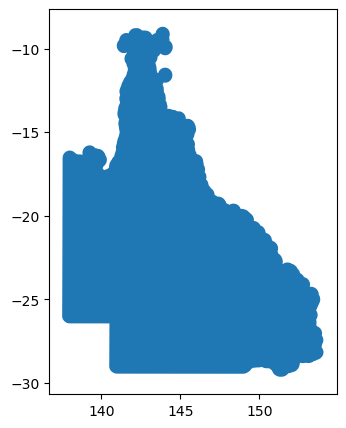

In [34]:
fig, ax = plt.subplots(
    figsize=(5, 5),
)

qld.plot(ax=ax)

Rebuild our dataset of roads within our expanded Queensland, using the same spatial join predicate, `within`

In [35]:
qld_roads = gpd.sjoin(
    r,
    qld,
    predicate='within',
)

Rebuild our array of road linewidths

In [37]:
qld_road_widths = [
    road_width[i] for i in qld_roads['GP_RTP']
]

Re-do our map of Queensland roads

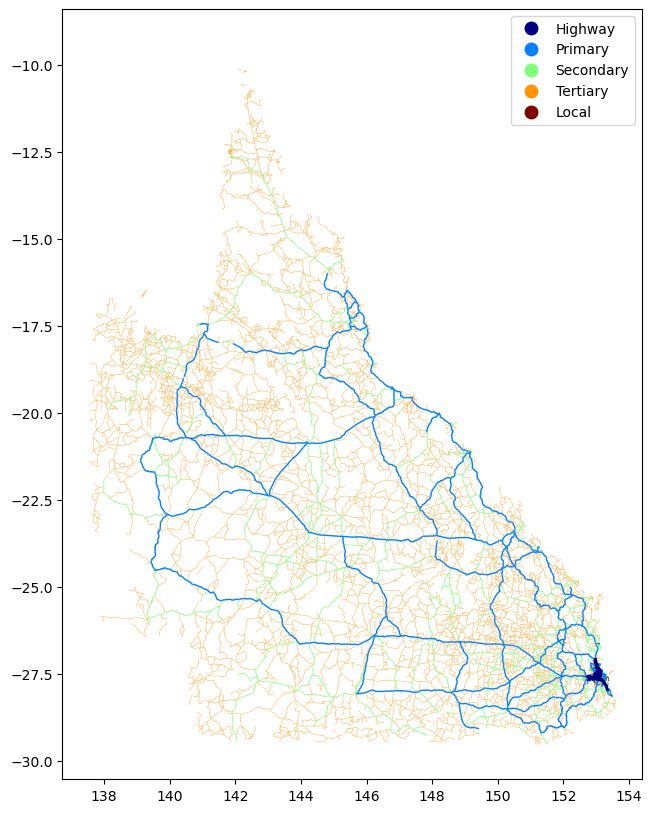

In [38]:
fig, axs = plt.subplots(
    figsize=(10, 10),
)

ax = axs
qld_roads.plot(
    ax=ax,
    column='GP_RTP',
    categorical=True,
    cmap='jet',
    legend=True,
    lw=qld_road_widths,
)

leg1 = ax.get_legend()
leg1.get_texts()[0].set_text('Highway')
leg1.get_texts()[1].set_text('Primary')
leg1.get_texts()[2].set_text('Secondary')
leg1.get_texts()[3].set_text('Tertiary')
leg1.get_texts()[4].set_text('Local')

plt.show()

Success!! now we have  our missing road back.

------------------------
### More refinements

We add a gray coastline.  We create a GeoPandas GeoDataFrame just for Queensland, converts to the Roads dataset CRS, and plot with a facecolor of `"none"`. We do a plot of just the coastline / border to check all is well (it is).

<Axes: >

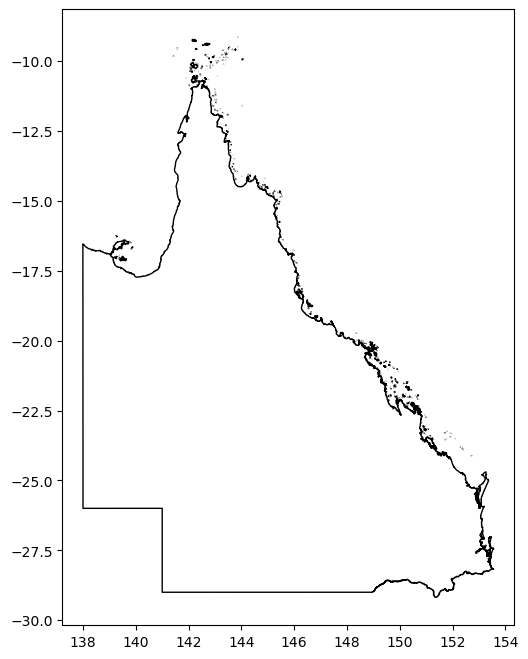

In [32]:
fig, ax = plt.subplots(figsize=(8, 8))

qld_coast = (
    oz[oz['STE_NAME21'] == 'Queensland']
    .to_crs(r.crs)
    .copy()
)

qld_coast.plot(
    ax=ax,
    facecolor='none',
    edgecolor='black',
)

Now combine the roads and coastline / border plots onto a single map.

I quite like the look of the roads going out past the border (like the fringe on a rug):  it reminds the viewer that the roads just don't stop at the border.

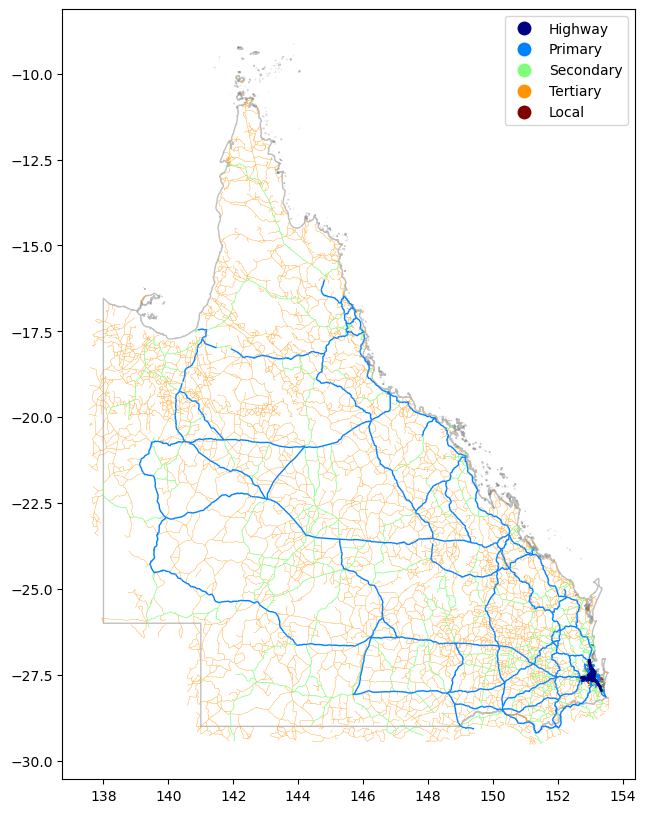

In [34]:
fig, axs = plt.subplots(
    figsize=(10, 10),
)

ax = axs
qld_roads.plot(
    ax=ax,
    column='GP_RTP',
    categorical=True,
    cmap='jet',
    legend=True,
    lw=qld_road_widths,
)

qld_coast.plot(
    ax=ax,
    facecolor='none',
    edgecolor='gray',
    alpha=0.5,
)

leg1 = ax.get_legend()
leg1.get_texts()[0].set_text('Highway')
leg1.get_texts()[1].set_text('Primary')
leg1.get_texts()[2].set_text('Secondary')
leg1.get_texts()[3].set_text('Tertiary')
leg1.get_texts()[4].set_text('Local')

plt.show()

## Conclusions / Summary

The main take-away is that using datasets from different source can have un-expected Gotchas when you try to use them together.

-------------------
## Reproducibility

### Notebook version status

In [40]:
%watermark

Last updated: 2025-04-15T20:05:10.474598+10:00

Python implementation: CPython
Python version       : 3.12.9
IPython version      : 9.0.2

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 11
Machine     : AMD64
Processor   : Intel64 Family 6 Model 170 Stepping 4, GenuineIntel
CPU cores   : 22
Architecture: 64bit



In [41]:
%watermark -h -iv

Hostname: INSPIRON16

pandas     : 2.2.3
shapely    : 2.0.6
matplotlib : 3.10.0
geodatasets: 2024.8.0
cartopy    : 0.24.1
geopandas  : 1.0.1



In [43]:
%watermark -co

conda environment: pythonmaps

